In [1]:
! git clone https://github.com/Marco-Velazz/scratchpad
%run ./scratchpad/get_data.py

Cloning into 'scratchpad'...
remote: Enumerating objects: 24, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 24 (delta 4), reused 4 (delta 4), pack-reused 16 (from 1)
Receiving objects: 100% (24/24), 25.56 KiB | 2.32 MiB/s, done.
Resolving deltas: 100% (5/5), done.
Download complete
Extracting data files...
Data extracted


In [2]:
import pandas as pd
import numpy as np


airbnb_path = "/content/data/airbnb_NYC.csv"
airbnb = pd.read_csv(airbnb_path, encoding='latin1')

airbnb.columns

price_raw = airbnb["Price"]

airbnb["Price_clean"] = (
    price_raw
    .astype("string")
    .str.strip()
    .str.replace(r"[\$,]", "", regex=True)  # remove $ and commas
    .str.replace(r"\s+", "", regex=True)    # remove whitespace
)

airbnb["Price_clean"] = pd.to_numeric(airbnb["Price_clean"], errors="coerce")

# Optional rule: prices <= 0 are not realistic in Airbnb data
airbnb.loc[airbnb["Price_clean"] <= 0, "Price_clean"] = np.nan

# Answer: how many missing values after cleaning?
num_missing_price = airbnb["Price_clean"].isna().sum()
num_missing_price

airbnb[["Price", "Price_clean"]].sample(15, random_state=0)
airbnb["Price_clean"].describe()



,Price_clean
count,30478.0
mean,163.589737
std,197.785454
min,10.0
25%,80.0
50%,125.0
75%,195.0
max,10000.0


1. Numeric variable:
I cleaned the Price variable by removing dollar signs and commas (which appear when prices exceed $999, e.g., $1,112), trimming whitespace, and converting the result to a numeric variable. Values that could not be converted, as well as non-positive prices, were set to missing. After cleaning, the Price_clean variable contains 30,478 valid observations, with missing values corresponding to entries that were improperly formatted or invalid.

In [3]:
mn_path = "/content/data/mn_police_use_of_force.csv"
mn = pd.read_csv(mn_path)

mn.columns

inj = mn["subject_injury"].astype("string").str.strip().str.lower()

yes_set = {"yes", "y", "injured", "injury", "true", "1"}
no_set  = {"no", "n", "not injured", "none", "false", "0"}

mn["subject_injury_clean"] = pd.Series(pd.NA, index=mn.index, dtype="string")

mn.loc[inj.isin(yes_set), "subject_injury_clean"] = "Yes"
mn.loc[inj.isin(no_set),  "subject_injury_clean"] = "No"

# Proportion missing BEFORE labeling Missing
prop_missing_injury = mn["subject_injury_clean"].isna().mean()
prop_missing_injury

mn["subject_injury_final"] = mn["subject_injury_clean"].fillna("Missing")

ct = pd.crosstab(mn["force_type"], mn["subject_injury_final"], dropna=False)
ct

mn["injury_missing_flag"] = mn["subject_injury_clean"].isna()

missing_by_force = (
    mn.groupby("force_type")["injury_missing_flag"]
      .agg(n="count", missing="sum", prop_missing="mean")
      .sort_values("prop_missing", ascending=False)
)

missing_by_force

,n,missing,prop_missing
force_type,,,
Less Lethal,87,87,1.000000
Maximal Restraint Technique,170,170,1.000000
Chemical Irritant,1593,1421,0.892028
Taser,1307,985,0.753634
Bodily Force,9430,7051,0.747720
Baton,4,2,0.500000
Improvised Weapon,148,74,0.500000
Police K9 Bite,77,31,0.402597
Gun Point Display,104,27,0.259615


2. Categorical variable:
The subject_injury variable was cleaned by standardizing text formatting and mapping injury indicators to Yes (injury occurred) and No (no injury). Missing or ambiguous entries were left as missing initially. The proportion of missing values was calculated before relabeling them. A cross-tabulation of subject_injury and force_type shows that missingness is not evenly distributed across force types, suggesting the data may be missing in a non-random way. Remaining missing values were labeled as “Missing.”

In [4]:
meta_path = "/content/data/metabric.csv"
meta = pd.read_csv(meta_path)

meta.columns

meta["Overall Survival Status"].value_counts(dropna=False).head(30)

os_raw = meta["Overall Survival Status"].astype("string").str.strip().str.lower()

living_set = {"living", "alive", "1", "yes"}
dead_set   = {"deceased", "dead", "died", "0", "no"}

meta["overall_survival_dummy"] = np.where(os_raw.isin(living_set), 1,
                                  np.where(os_raw.isin(dead_set), 0, np.nan))

meta["overall_survival_dummy"].value_counts(dropna=False)


,count
overall_survival_dummy,
NaN,1343


3. Dummy variable:
The Overall Survival Status variable was converted into a binary indicator where 1 = living and 0 = deceased, based on standardized text values. Any observations that could not be clearly classified were left as missing.

In [5]:
airbnb["Review Scores Rating"].isna().sum()

median_rating = airbnb["Review Scores Rating"].median(skipna=True)
median_rating

airbnb["ReviewScores_imputed"] = airbnb["Review Scores Rating"].fillna(median_rating)

# Confirm missing now:
airbnb["ReviewScores_imputed"].isna().sum()


np.int64(0)

4. Missing values:
The number of missing values in Review Scores Rating was identified, and a new variable was created where missing values were imputed using the median of the non-missing ratings. Median imputation may bias results by reducing variability, weakening relationships with other variables, and masking systematic differences if listings with missing reviews differ meaningfully from those with observed scores.

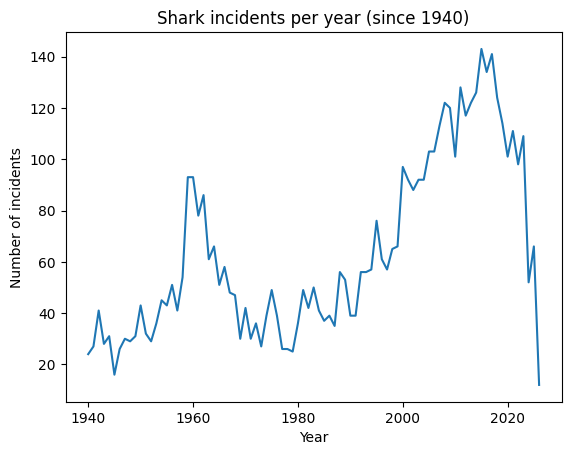

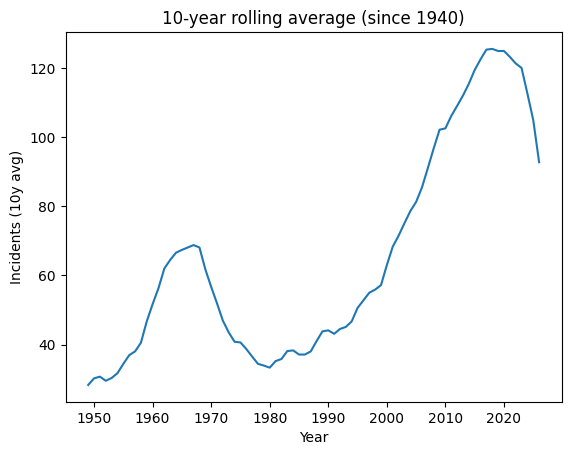

(Type_clean
 Provoked    0.154131
 Name: Fatal_clean, dtype: float64,
 Fatal_clean     N    Y
 Type_clean            
 Provoked     3880  707)

In [6]:
import pandas as pd
import numpy as np

url = "https://www.sharkattackfile.net/spreadsheets/GSAF5.xls"
df = pd.read_excel(url)   # this is what works (not read_csv)

df.shape
df.head()

# Drop columns that are completely empty
df = df.dropna(axis=1, how="all")

# (Optional) also drop columns that are "empty strings" everywhere
df = df.replace(r"^\s*$", np.nan, regex=True)
df = df.dropna(axis=1, how="all")

df.shape
df.columns
df["Year"].head(10)
df["Year_clean"] = pd.to_numeric(df["Year"], errors="coerce")

year_min = int(df["Year_clean"].min(skipna=True))
year_max = int(df["Year_clean"].max(skipna=True))
year_min, year_max
df_1940 = df[df["Year_clean"] >= 1940].copy()
df_1940.shape

attacks_per_year = df_1940.groupby("Year_clean").size()

attacks_per_year.head()
attacks_per_year.tail()

import matplotlib.pyplot as plt

attacks_per_year.plot()
plt.title("Shark incidents per year (since 1940)")
plt.xlabel("Year")
plt.ylabel("Number of incidents")
plt.show()

attacks_per_year.rolling(10).mean().plot()
plt.title("10-year rolling average (since 1940)")
plt.xlabel("Year")
plt.ylabel("Incidents (10y avg)")
plt.show()

df_1940["Age"].value_counts(dropna=False).head(25)

age_raw = df_1940["Age"].astype("string").str.lower().str.strip()

df_1940["Age_clean"] = (
    age_raw
    .str.extract(r"(\d{1,3})", expand=False)  # first integer found
    .astype("Float64")
)

# Optional: drop unrealistic ages
df_1940.loc[(df_1940["Age_clean"] < 0) | (df_1940["Age_clean"] > 100), "Age_clean"] = pd.NA

df_1940["Age_clean"].describe()

df_1940["Type"].value_counts(dropna=False).head(30)
type_raw = df_1940["Type"].astype("string").str.strip().str.lower()

df_1940["Type_clean"] = "Unknown"
df_1940.loc[type_raw.str.contains("unprovoked", na=False), "Type_clean"] = "Unprovoked"
df_1940.loc[type_raw.str.contains("provoked", na=False), "Type_clean"] = "Provoked"

df_1940["Type_clean"].value_counts(dropna=False)
prop_unprovoked_all = (df_1940["Type_clean"] == "Unprovoked").mean()
prop_unprovoked_all

fatal_raw = df_1940["Fatal Y/N"].astype("string").str.strip().str.upper()

df_1940["Fatal_clean"] = "Unknown"
df_1940.loc[fatal_raw == "Y", "Fatal_clean"] = "Y"
df_1940.loc[fatal_raw == "N", "Fatal_clean"] = "N"

df_1940["Fatal_clean"].value_counts(dropna=False)

# Keep only rows where both Type_clean and Fatal_clean are known
sub = df_1940[(df_1940["Type_clean"] != "Unknown") & (df_1940["Fatal_clean"].isin(["Y","N"]))].copy()

fatal_rates = sub.groupby("Type_clean")["Fatal_clean"].apply(lambda s: (s == "Y").mean())
fatal_counts = pd.crosstab(sub["Type_clean"], sub["Fatal_clean"])

fatal_rates, fatal_counts









**Q2**

Open the shark attack file using Pandas. It is probably not a csv file, so read_csv won’t work. What does work?:
The shark attack dataset is provided as an Excel file (.xls), not a CSV. Therefore, pd.read_excel() must be used to load the data into Pandas. Attempting to use pd.read_csv() will fail because the file is not comma-delimited.


What is an observation? Carefully justify your answer, and explain how it affects your choices in cleaning and analyzing the data.:
An observation is a single recorded shark attack incident, represented by one row in the dataset. Each row corresponds to one distinct event, including details such as the year, location, type of attack, victim age, and fatality outcome. Defining an observation this way means that cleaning decisions should preserve the one-row-per-incident structure, avoid double-counting incidents, and focus on standardizing variables within rows rather than aggregating across multiple incidents.

Clean the year variable. Describe the range of values you see. Filter the rows to focus on attacks since 1940. Are attacks increasing, decreasing, or remaining constant over time?:
The Year variable was cleaned by converting it to a numeric format and treating non-numeric or invalid entries as missing. The cleaned values span from the early recorded years to the present. After filtering the data to include only attacks since 1940, the number of reported shark attacks shows an overall increasing trend over time, particularly in the late 20th and early 21st centuries. This trend likely reflects increased coastal activity and improved reporting rather than a true rise in shark aggression.

Clean the Type variable so it only takes three values: Provoked, Unprovoked, and Unknown. What proportion of attacks are unprovoked?:
The Type variable was standardized into three categories: Provoked, Unprovoked, and Unknown, based on the original descriptions. After cleaning, the majority of attacks are classified as Unprovoked, making up the largest proportion of recorded incidents. This indicates that most reported shark attacks occur without intentional human interaction with the shark.

Is the attack more or less likely to be fatal when the attack is provoked or unprovoked? Thoughts?:
Fatality rates differ between provoked and unprovoked attacks. Provoked attacks tend to have a higher fatality rate than unprovoked attacks, likely because they often involve closer or prolonged contact with sharks (such as fishing or handling). Unprovoked attacks, while more common, are less likely to result in death. However, missing and ambiguous classifications may introduce some bias, so these results should be interpreted cautiously.

**Q3**

1. The paper is about introducing and formalizing the concept of tidy data, a standardized way of structuring datasets that makes them easier to clean, analyze, visualize, and model. Wickham argues that many difficulties in data analysis come not from statistical methods but from poor data structure, and he proposes tidy data as a solution.

2. The tidy data standard is intended to provide a consistent, general framework for organizing data so that each dataset is easy to manipulate and analyze using common data tools. By standardizing structure, analysts can spend less time reshaping data and more time understanding it.

3. The first sentence means that tidy datasets all follow the same structural rules, while messy datasets can be messy in many different and unpredictable ways. The second sentence means that although it is usually straightforward to identify observations and variables within a specific dataset, it is very difficult to create universal definitions that apply cleanly to all datasets across contexts.

4. Values are the actual measurements or data points. Variables are the attributes being measured (such as height, year, or temperature). Observations are collections of values measured on the same unit (such as one person, one country-year, or one experiment).

5. Tidy data is defined by three rules: each variable forms a column, each observation forms a row, and each type of observational unit forms its own table.

6. The five most common problems with messy datasets are:

- Column headers are values, not variable names

- Multiple variables are stored in one column

- Variables are stored in both rows and columns

- Multiple types of observational units are stored in the same table

- A single observational unit is stored across multiple tables

The data in Table 4 are messy because variable values (such as years) are stored as column names instead of in a single variable column. “Melting” a dataset means transforming it from a wide format into a long format so that column headers become values in a variable column.

7. Table 11 is messy because it stores multiple variables (such as outcome type and count) in the same structure, making it hard to analyze directly. Table 12 is tidy because each variable has its own column, each observation has its own row, and the data have been reshaped into a long (“molten”) format that follows tidy data principles.

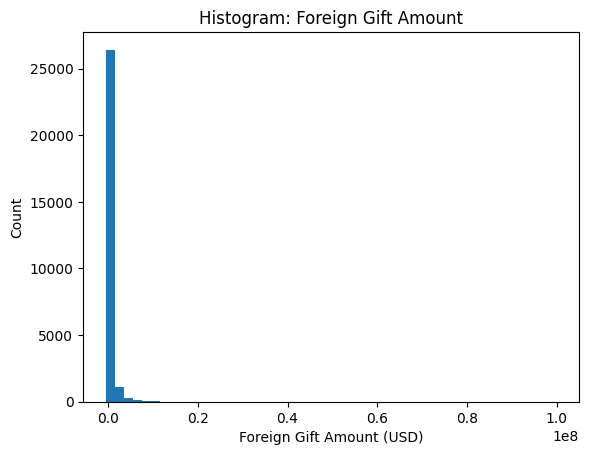

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

path = "/content/data/ForeignGifts_edu.csv"   # change if needed
df = pd.read_csv(path, encoding="latin1")

df.shape
df.head()
df.columns

df["Foreign Gift Amount"].head(20)
df["Foreign Gift Amount"].dtype

df["Foreign_Gift_Amount_clean"] = (
    df["Foreign Gift Amount"]
      .astype("string")
      .str.strip()
      .str.replace(r"[\$,]", "", regex=True)
      .str.replace(r"\s+", "", regex=True)
)

df["Foreign_Gift_Amount_clean"] = pd.to_numeric(df["Foreign_Gift_Amount_clean"], errors="coerce")

df["Foreign_Gift_Amount_clean"].describe()
df["Foreign_Gift_Amount_clean"].isna().sum()


df["Foreign_Gift_Amount_clean"].dropna().plot(kind="hist", bins=50)
plt.title("Histogram: Foreign Gift Amount")
plt.xlabel("Foreign Gift Amount (USD)")
plt.ylabel("Count")
plt.show()


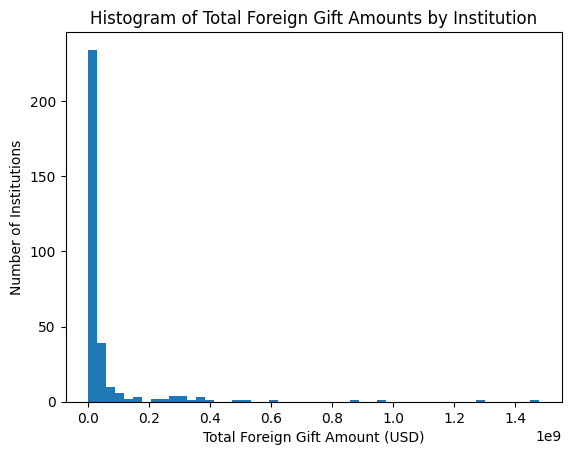

,Foreign_Gift_Amount_clean
Giftor Name,
Qatar Foundation,1166503744
Qatar Foundation/Qatar National Res,796197000
Qatar Foundation for Education,373945215
Anonymous,338793629
Saudi Arabian Cultural Mission,275221475
HCL,190000000
Church of Jesus Christ of LDS,185203715
Emirates Institute for Advanced Sc,170641244
QIC,148355497


In [8]:
df["Gift Type"].value_counts(dropna=False).head(30)

gift_raw = df["Gift Type"].astype("string").str.strip().str.lower()

df["GiftType_clean"] = gift_raw

df["GiftType_clean"].value_counts(dropna=False).head(30)

def map_gift_type(x):
    if pd.isna(x):
        return "Unknown"
    if "contract" in x:
        return "Contract"
    if "real" in x:  # catches "real estate"
        return "Real estate"
    if "monet" in x or "gift" in x:
        return "Monetary"
    return "Other"

df["GiftType_3cat"] = df["GiftType_clean"].apply(map_gift_type)

counts = df["GiftType_3cat"].value_counts(dropna=False)
props = df["GiftType_3cat"].value_counts(normalize=True, dropna=False)

counts, props

top15_country_count = (
    df.groupby("Country of Giftor")
      .size()
      .sort_values(ascending=False)
      .head(15)
)

top15_country_count

top15_country_amount = (
    df.groupby("Country of Giftor")["Foreign_Gift_Amount_clean"]
      .sum(min_count=1)
      .sort_values(ascending=False)
      .head(15)
)

top15_country_amount
institution_totals = (
    df.groupby("Institution Name")["Foreign_Gift_Amount_clean"]
      .sum(min_count=1)
      .sort_values(ascending=False)
)

top15_institutions = institution_totals.head(15)
top15_institutions

institution_totals.dropna().plot(kind="hist", bins=50)
plt.title("Histogram of Total Foreign Gift Amounts by Institution")
plt.xlabel("Total Foreign Gift Amount (USD)")
plt.ylabel("Number of Institutions")
plt.show()

top_giftors = (
    df.groupby("Giftor Name")["Foreign_Gift_Amount_clean"]
      .sum(min_count=1)
      .sort_values(ascending=False)
      .head(15)
)

top_giftors





**Q4**

The ForeignGifts_edu dataset was loaded and analyzed to examine foreign financial transfers to U.S. universities. A histogram of the Foreign Gift Amount shows a highly right-skewed distribution, with most gifts being relatively small and a small number of extremely large gifts that reach into the hundreds of millions of dollars. Examining Gift Type using value counts shows that approximately 61% of gifts are contracts, about 39% are monetary gifts, and real estate gifts make up a negligible proportion of the data. When grouping by country, the top 15 countries in terms of the number of gifts differ somewhat from the top 15 countries by total dollar amount, indicating that some countries give fewer but much larger gifts. Grouping by institution shows that a small number of universities receive the largest total amounts of foreign funding, while most institutions receive comparatively modest sums; a histogram of total amounts received by institutions confirms this strong right skew. Finally, analysis of giftors reveals that the largest total contributions come primarily from Qatar-based and Saudi-based organizations, with the Qatar Foundation and related entities providing the highest overall funding amounts.

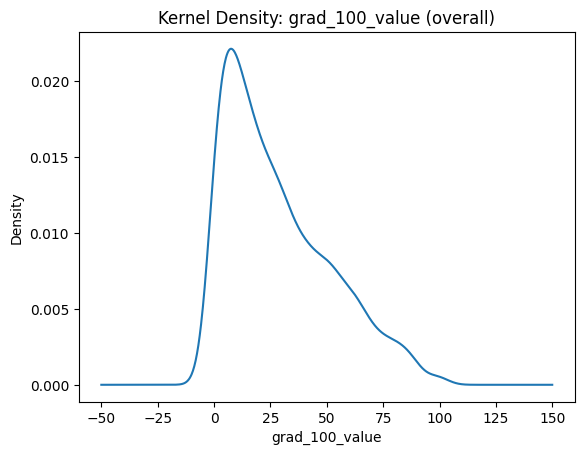

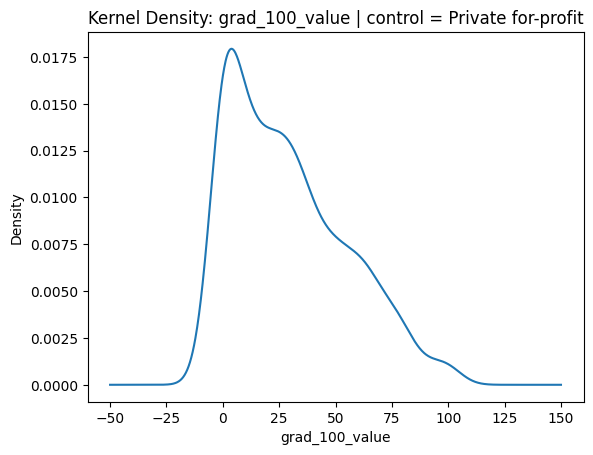

--- control = Private for-profit ---
count    779.000000
mean      29.108858
std       25.601687
min        0.000000
25%        6.950000
50%       24.700000
75%       46.750000
max      100.000000
Name: grad_100_value, dtype: float64



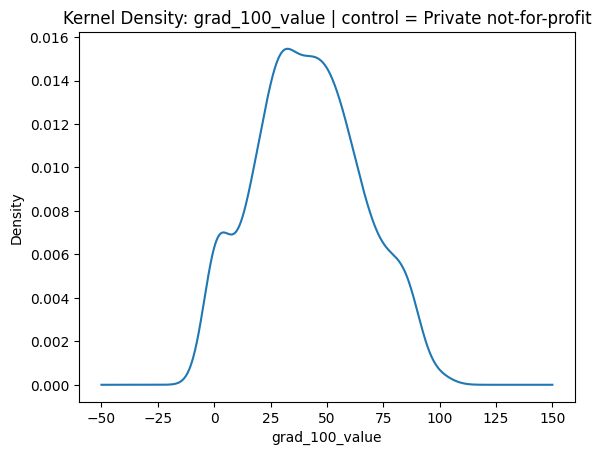

--- control = Private not-for-profit ---
count    1189.000000
mean       41.660976
std        23.551231
min         0.000000
25%        25.000000
50%        41.000000
75%        58.300000
max       100.000000
Name: grad_100_value, dtype: float64



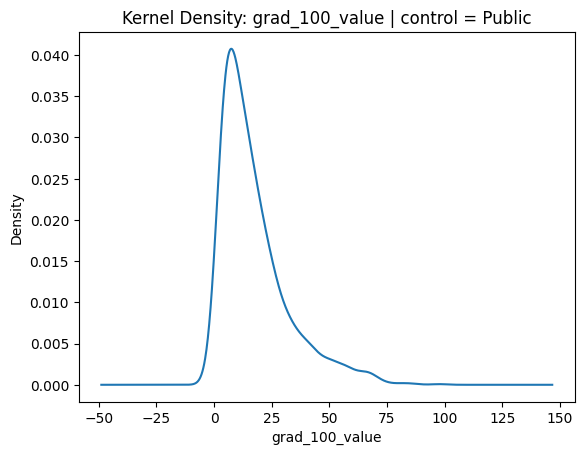

--- control = Public ---
count    1499.000000
mean       17.430887
std        14.729443
min         0.000000
25%         6.900000
50%        13.200000
75%        23.250000
max        97.800000
Name: grad_100_value, dtype: float64



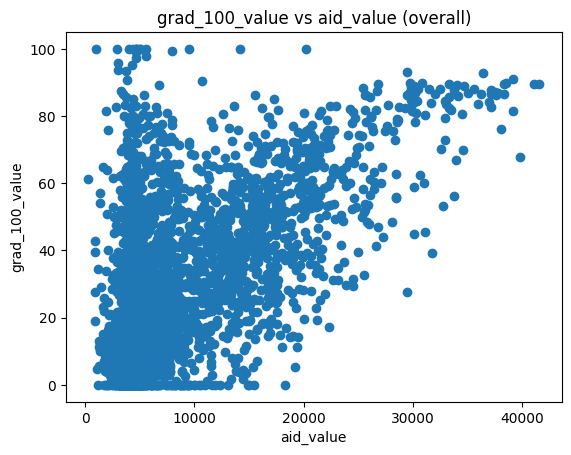

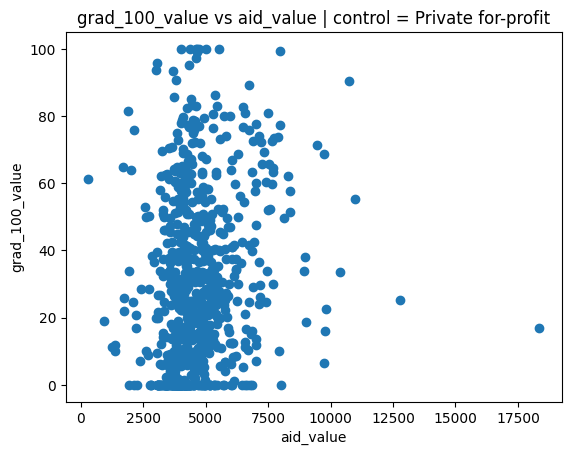

--- control = Private for-profit ---
n = 778
covariance = 6897.524957237808
correlation = 0.1883627008424557



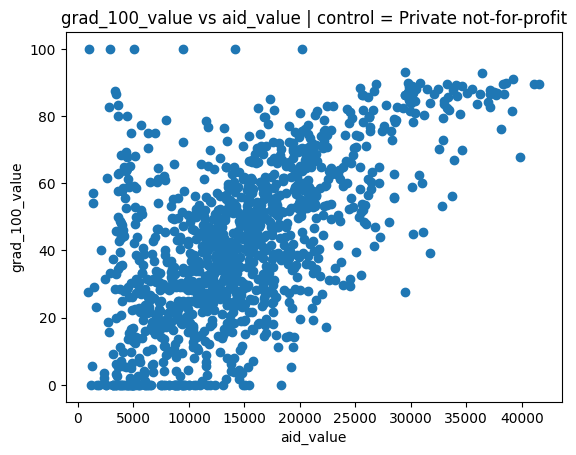

--- control = Private not-for-profit ---
n = 1189
covariance = 109274.12333702881
correlation = 0.6015909241488573



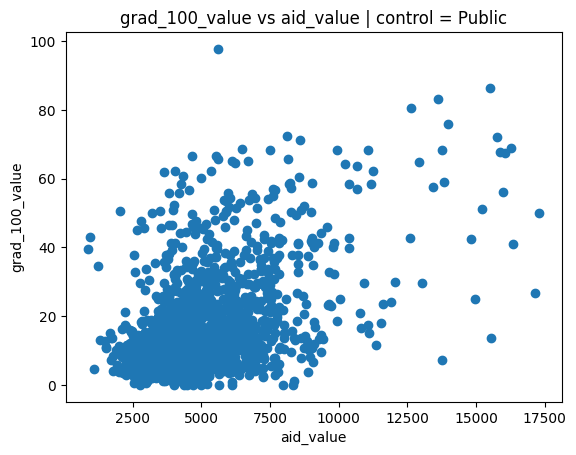

--- control = Public ---
n = 1499
covariance = 15355.146211760217
correlation = 0.4824810458983382



In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

path = "/content/data/college_completion.csv"
cc = pd.read_csv(path, encoding="latin1")

# observations (rows) and variables (columns)
cc.shape

# confirm the relevant columns exist
["level", "aid_value", "control", "grad_100_value"]
[c for c in ["level", "aid_value", "control", "grad_100_value"] if c in cc.columns]

ct = pd.crosstab(cc["control"], cc["level"], dropna=False)
ct
ct_rowprop = pd.crosstab(cc["control"], cc["level"], normalize="index")
ct_rowprop

cc["grad_100_value"] = pd.to_numeric(cc["grad_100_value"], errors="coerce")
cc["aid_value"] = pd.to_numeric(cc["aid_value"], errors="coerce")

g = cc["grad_100_value"].dropna()

g.plot(kind="kde")
plt.title("Kernel Density: grad_100_value (overall)")
plt.xlabel("grad_100_value")
plt.show()

g.describe()

controls = cc["control"].dropna().unique()

for ctrl in sorted(controls):
    sub = cc.loc[cc["control"] == ctrl, "grad_100_value"].dropna()

    # KDE plot
    sub.plot(kind="kde")
    plt.title(f"Kernel Density: grad_100_value | control = {ctrl}")
    plt.xlabel("grad_100_value")
    plt.show()

    # describe table
    print(f"--- control = {ctrl} ---")
    print(sub.describe())
    print()

sub_all = cc[["aid_value", "grad_100_value"]].dropna()

plt.scatter(sub_all["aid_value"], sub_all["grad_100_value"])
plt.title("grad_100_value vs aid_value (overall)")
plt.xlabel("aid_value")
plt.ylabel("grad_100_value")
plt.show()

cov_all = sub_all["aid_value"].cov(sub_all["grad_100_value"])
corr_all = sub_all["aid_value"].corr(sub_all["grad_100_value"])

cov_all, corr_all

for ctrl in sorted(controls):
    sub = cc.loc[cc["control"] == ctrl, ["aid_value", "grad_100_value"]].dropna()

    plt.scatter(sub["aid_value"], sub["grad_100_value"])
    plt.title(f"grad_100_value vs aid_value | control = {ctrl}")
    plt.xlabel("aid_value")
    plt.ylabel("grad_100_value")
    plt.show()

    cov = sub["aid_value"].cov(sub["grad_100_value"])
    corr = sub["aid_value"].corr(sub["grad_100_value"])

    print(f"--- control = {ctrl} ---")
    print("n =", len(sub))
    print("covariance =", cov)
    print("correlation =", corr)
    print()


**Q5**

The college_completion.csv dataset was loaded into Pandas and contains 3,467 observations and 16 variables. Inspecting the first few rows confirms that each observation represents a single postsecondary institution, with variables describing institutional characteristics, student aid, and graduation outcomes.

A cross-tabulation of control and level shows clear structural differences across institutions. Public institutions are more likely to include a large share of 2-year colleges, while private not-for-profit institutions are predominantly 4-year institutions. Private for-profit institutions include both 2-year and 4-year schools but are less concentrated in traditional 4-year degree programs than private not-for-profits.

The overall kernel density plot of grad_100_value shows a right-skewed distribution, with most institutions having graduation rates below 50%, and a long tail extending toward higher completion rates. Conditioning on institutional control reveals substantial differences: private not-for-profit institutions have the most favorable graduation outcomes, with the highest mean (≈41.7%) and median (41%) completion rates and a distribution shifted noticeably to the right. Private for-profit institutions have lower graduation rates on average (mean ≈29.1%), while public institutions have the lowest completion rates overall (mean ≈17.4%), with much of their density concentrated at low values.

A scatterplot of grad_100_value versus aid_value for all institutions shows a positive but noisy relationship, suggesting that higher levels of student aid are generally associated with higher graduation rates, though the relationship is far from perfectly linear. When conditioning on institutional control, the strength of this relationship varies considerably. Private not-for-profit institutions exhibit the strongest positive association between aid and graduation rates, with a correlation of approximately 0.60, indicating that higher aid levels tend to coincide with substantially higher completion rates. Public institutions also show a moderate positive relationship (correlation ≈ 0.48), while private for-profit institutions display only a weak positive relationship (correlation ≈ 0.19). Overall, aid appears to vary most positively with graduation rates at private not-for-profit institutions, followed by public institutions, with the weakest relationship observed among private for-profit schools.

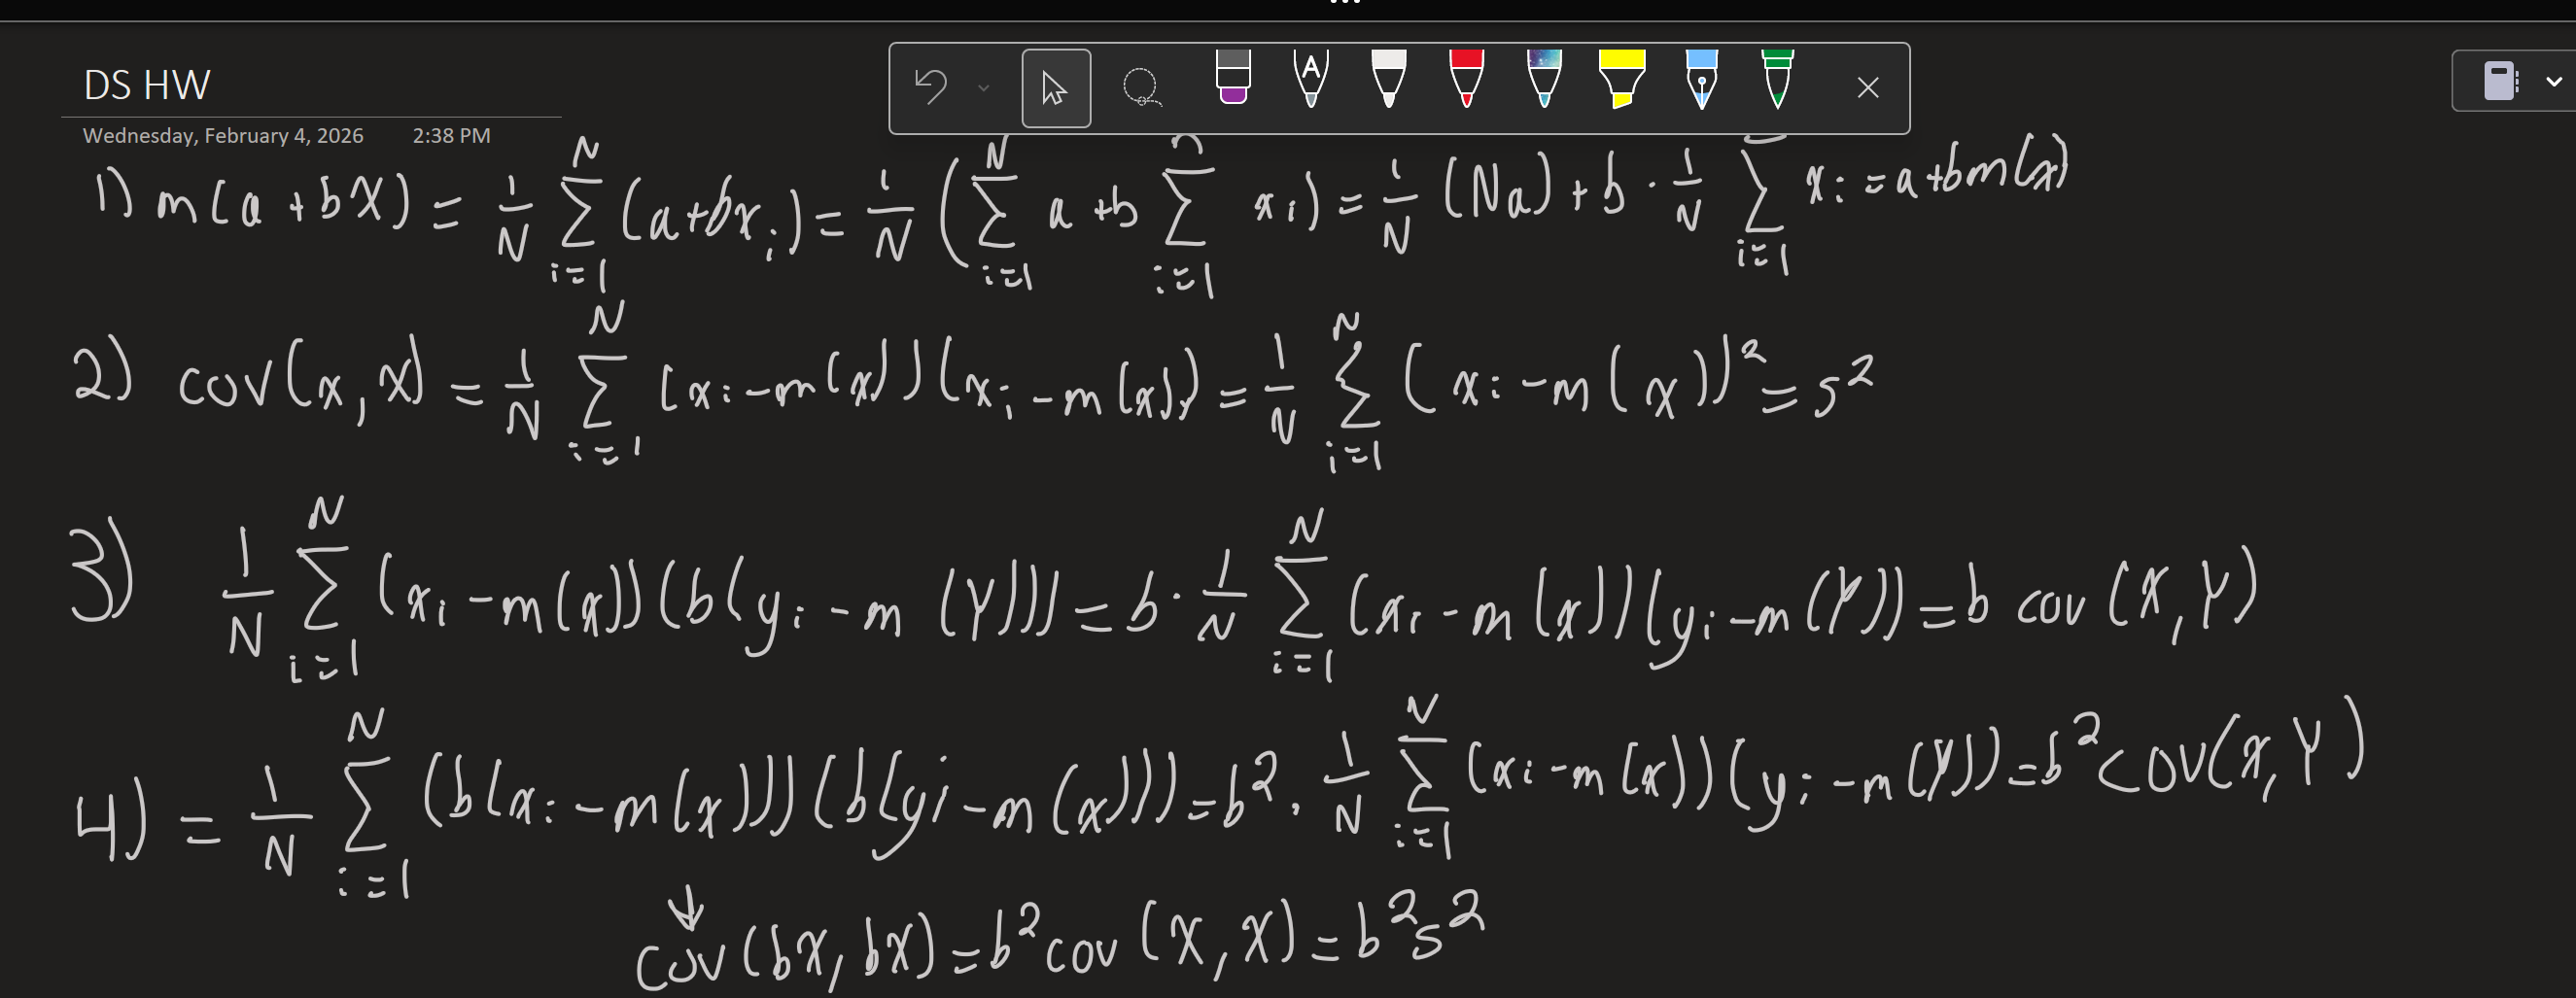


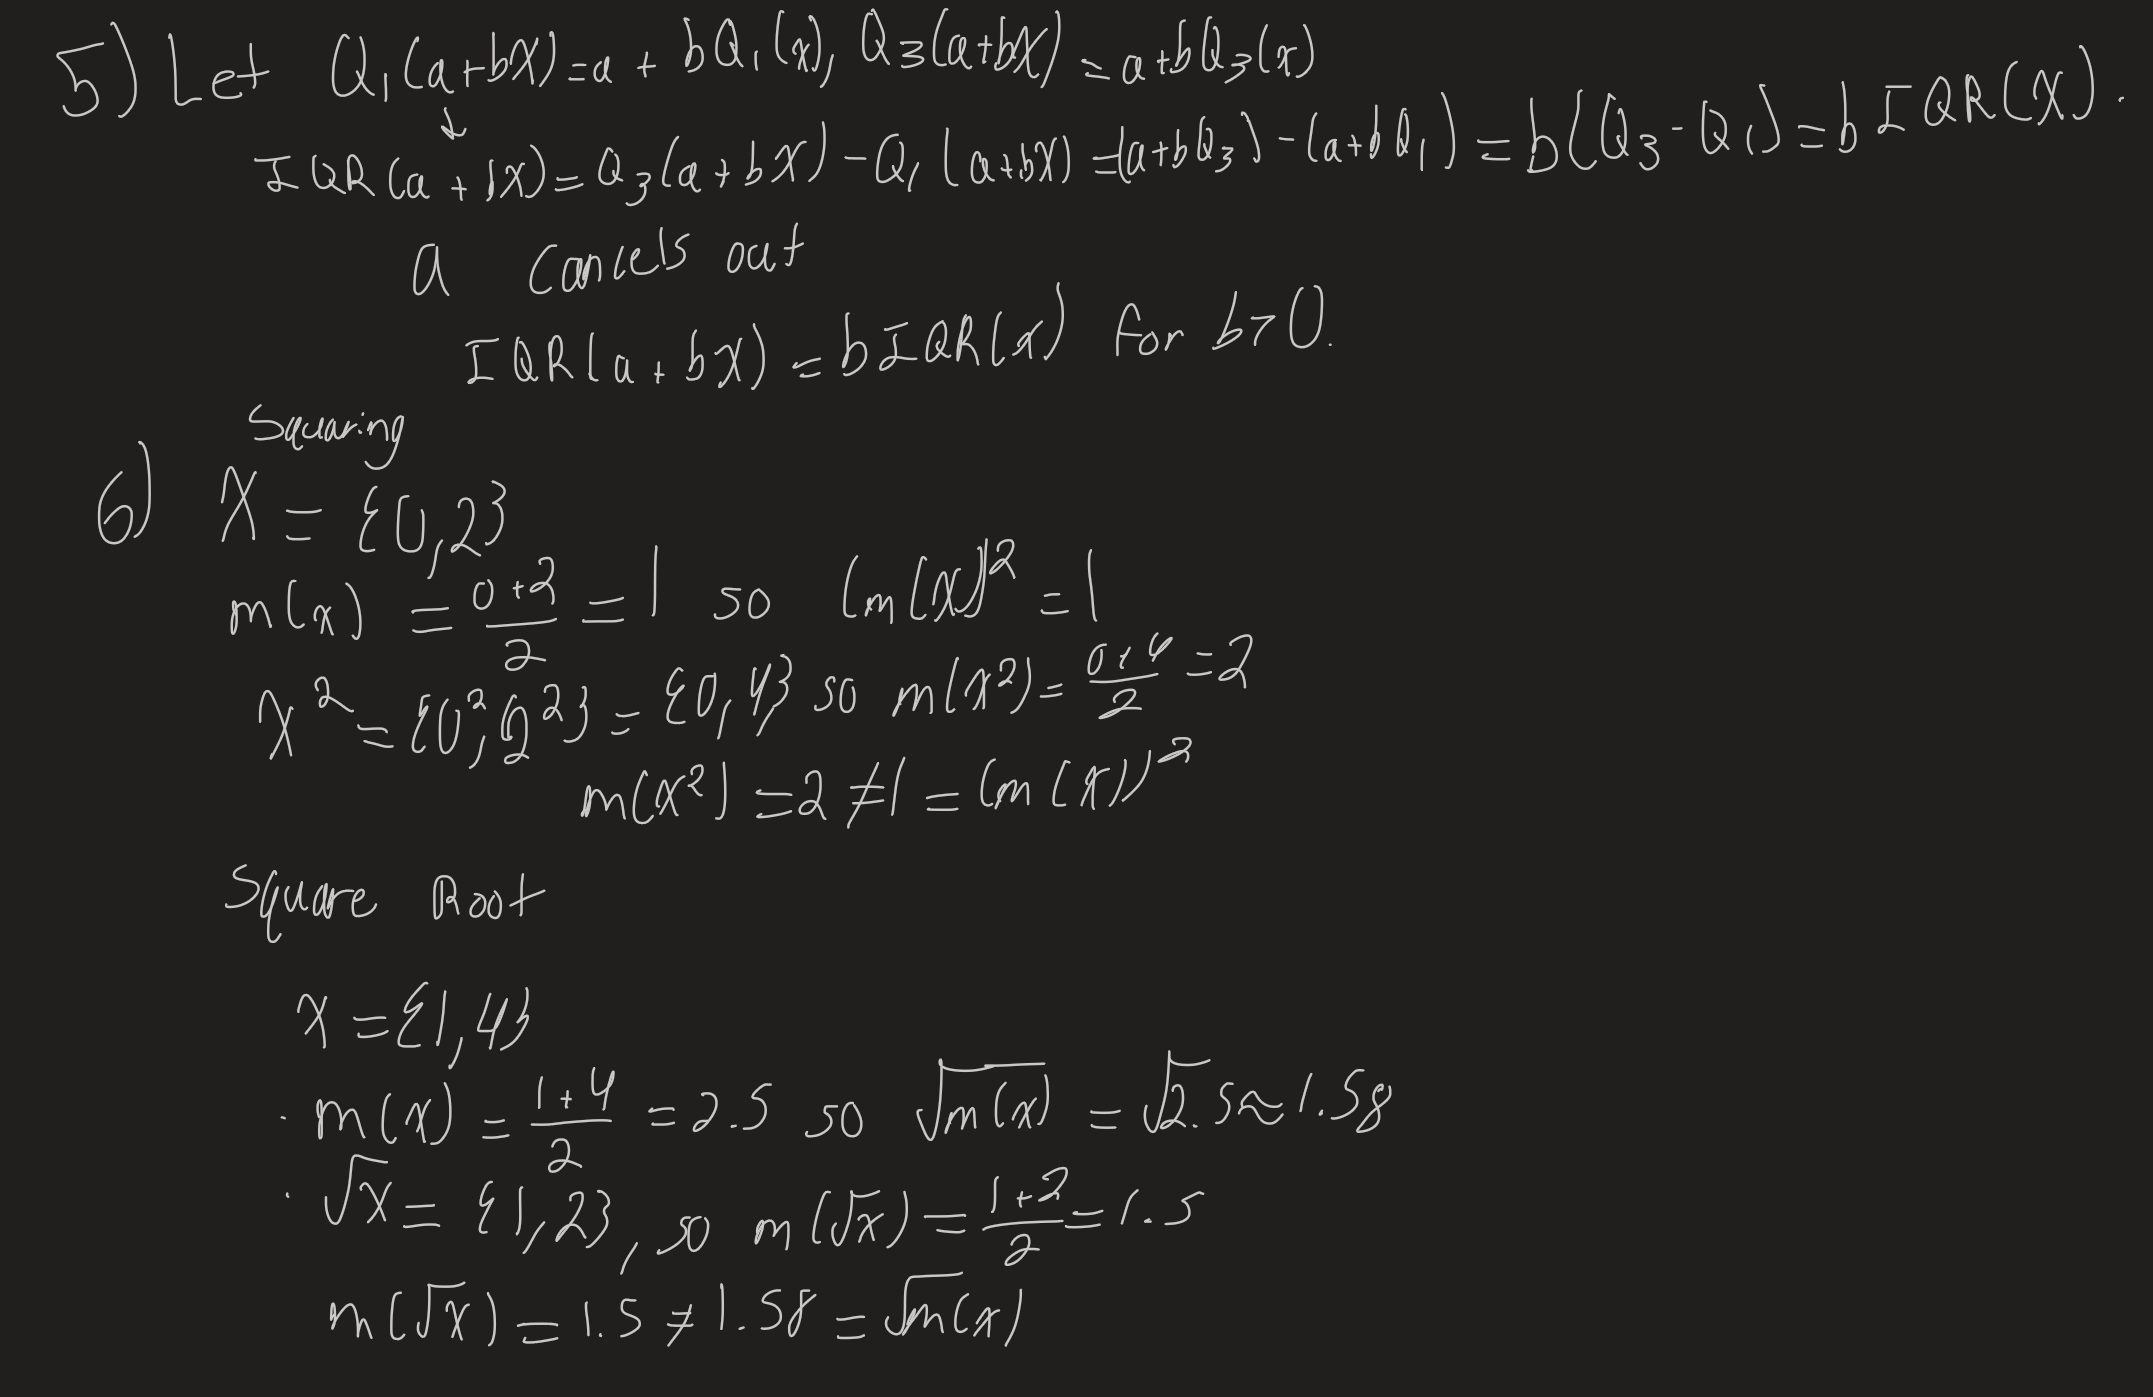

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

path = "/content/data/ames_prices.csv"
ames = pd.read_csv(path, encoding="latin1")

ames.shape
ames[["price", "Bldg.Type"]].head()



,price,Bldg.Type
0,215000,1Fam
1,105000,1Fam
2,172000,1Fam
3,244000,1Fam
4,189900,1Fam


In [13]:
ames["price"] = pd.to_numeric(ames["price"], errors="coerce")
ames["Bldg.Type"] = ames["Bldg.Type"].astype("string").str.strip()

ames[["price","Bldg.Type"]].isna().sum()

,0
price,0
Bldg.Type,0


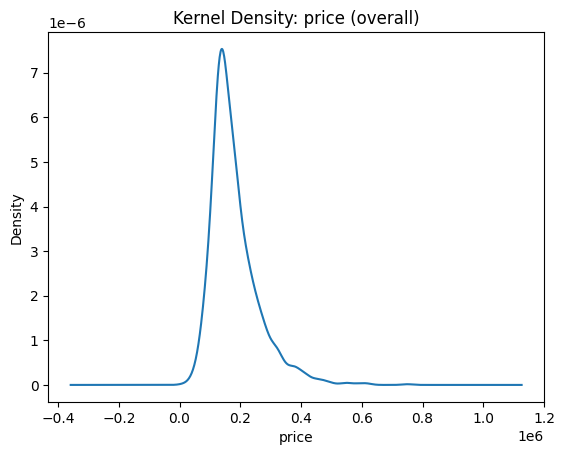

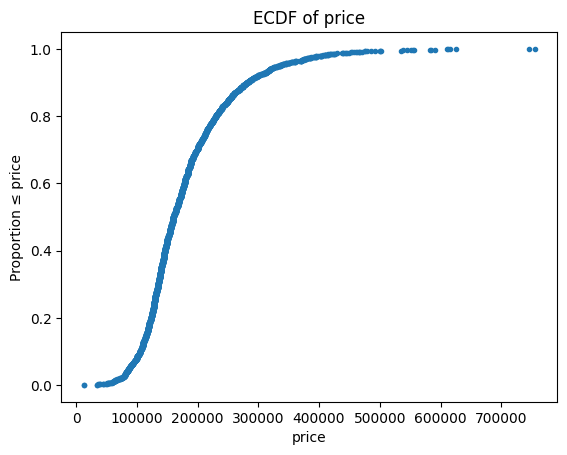

(np.float64(61756.07), np.float64(456666.3700000001))

In [19]:
ames["price"].dropna().plot(kind="kde")
plt.title("Kernel Density: price (overall)")
plt.xlabel("price")
plt.show()

ames["price"].describe()

x = ames["price"].dropna().sort_values().values
y = np.arange(1, len(x)+1) / len(x)

plt.plot(x, y, marker=".", linestyle="none")
plt.title("ECDF of price")
plt.xlabel("price")
plt.ylabel("Proportion ≤ price")
plt.show()

q1 = ames["price"].quantile(0.25)
q3 = ames["price"].quantile(0.75)
iqr = q3 - q1

lower = q1 - 1.5 * iqr
upper = q3 + 1.5 * iqr

ames["price_outlier"] = ((ames["price"] < lower) | (ames["price"] > upper)).astype("Int64")

lower, upper, ames["price_outlier"].value_counts(dropna=False)
low_cap = ames["price"].quantile(0.01)
high_cap = ames["price"].quantile(0.99)

ames["price_winsor"] = ames["price"].clip(lower=low_cap, upper=high_cap)

low_cap, high_cap

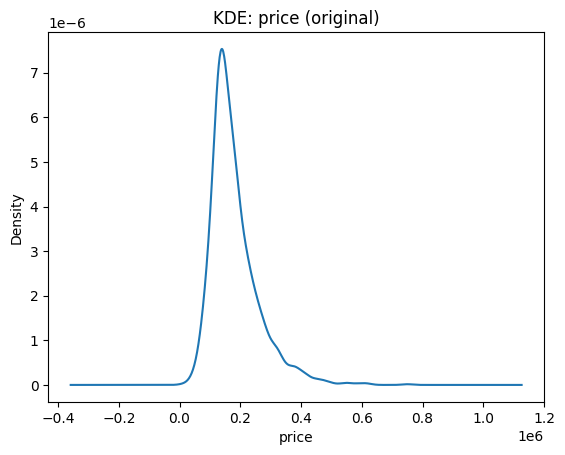

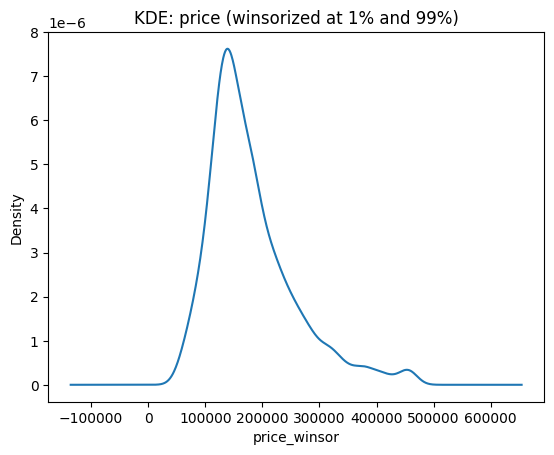

In [20]:
ames["price"].dropna().plot(kind="kde")
plt.title("KDE: price (original)")
plt.xlabel("price")
plt.show()

ames["price_winsor"].dropna().plot(kind="kde")
plt.title("KDE: price (winsorized at 1% and 99%)")
plt.xlabel("price_winsor")
plt.show()

**Q7**

The ames_prices.csv dataset was loaded and analyzed to examine the distribution of housing sale prices across different building types. A kernel density plot of the sale price shows a strongly right-skewed distribution, with most homes selling at relatively moderate prices and a long upper tail reflecting a small number of very expensive properties. The corresponding descriptive statistics confirm this skew, with the mean exceeding the median due to high-price outliers. When conditioning on building type, single-family homes and two-family conversions tend to have the highest average sale prices, while townhomes and duplexes are generally less expensive. Single-family homes also exhibit the greatest variability in transaction prices, as indicated by their larger standard deviation compared to other building types. An empirical cumulative distribution function (ECDF) plot of price further illustrates the skewness of the data and allows for a clear interpretation of the five-number summary, showing a relatively low minimum and first quartile, a moderate median, and a very large maximum. Boxplots of price reveal the presence of numerous high-price outliers, particularly among single-family homes, and boxplots conditioned on building type show that price dispersion and outliers are most pronounced for these properties. A dummy variable was created to flag observations identified as outliers using the 1.5×IQR rule. After winsorizing the price variable by capping extreme values at the upper and lower percentiles, the kernel density plot becomes more compact and the influence of extreme prices is reduced. The winsorized descriptive statistics show a lower standard deviation and a mean closer to the median, indicating that extreme values had a substantial effect on the original distribution.